In [4]:
import os
import torch
import tarfile
import torchvision
import torch.nn as nn
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_url
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
import imageio
from pathlib import Path
import skimage
from skimage import io
from IPython.display import clear_output
# import efficientnet_pytorch
# from efficientnet_pytorch import EfficientNet

In [5]:
# 4/1AY0e-g6BwSDQqELiUtGjpEbkmxY0SEpEqOA-rd7DzaKnarZKe2r2Gehg2gE

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# План работы
1) Предобработка данных(поизучать данные, посмотреть распределение классов, сделать более удобные метки)

2) Создание датасета(добавление аугментации, нормализации, изменение размеров для моделей)

3)Построение моделей(построить несколько моделей классификации, обучить, выбрать лучшую)

#1. Предобработка данных

Посмотрим, что представляет собой датасет

In [7]:
df = pd.read_csv('/content/drive/My Drive/sber/imagewoof2/noisy_imagewoof.csv', sep = ',')
df

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,train/n02115641/n02115641_3995.JPEG,n02115641,n02115641,n02115641,n02115641,n02115641,False
1,train/n02115641/n02115641_843.JPEG,n02115641,n02115641,n02105641,n02115641,n02088364,False
2,train/n02115641/n02115641_2953.JPEG,n02115641,n02115641,n02115641,n02111889,n02099601,False
3,train/n02115641/n02115641_6458.JPEG,n02115641,n02115641,n02115641,n02093754,n02115641,False
4,train/n02115641/n02115641_19414.JPEG,n02115641,n02115641,n02115641,n02115641,n02088364,False
...,...,...,...,...,...,...,...
12949,val/n02089973/n02089973_9351.JPEG,n02089973,n02089973,n02089973,n02089973,n02089973,True
12950,val/n02089973/n02089973_1241.JPEG,n02089973,n02089973,n02089973,n02089973,n02089973,True
12951,val/n02089973/n02089973_4702.JPEG,n02089973,n02089973,n02089973,n02089973,n02089973,True
12952,val/n02089973/n02089973_1040.JPEG,n02089973,n02089973,n02089973,n02089973,n02089973,True


In [8]:
df['path'] = '/content/drive/My Drive/sber/imagewoof2/' + df['path']

Мы видим, что таргеты имеют тип str, найдём все уникальные значения и перезапишем их числами от [0..n]

In [9]:
df.noisy_labels_0.unique()
idx1 = {} #словарь для замены имени таргета
for i in range(len(df.noisy_labels_0.unique())):
    idx1[df.noisy_labels_0.unique()[i]] = i
idx2 = {v: k for k, v in idx1.items()}
#заменяем
df['noisy_labels_0'].replace(idx1, inplace=True)
df['noisy_labels_1'].replace(idx1, inplace=True)
df['noisy_labels_5'].replace(idx1, inplace=True)
df['noisy_labels_25'].replace(idx1, inplace=True)
df['noisy_labels_50'].replace(idx1, inplace=True)
df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid
0,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,0,0,0,False
1,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,4,0,2,False
2,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,0,5,6,False
3,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,0,8,0,False
4,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,0,0,2,False


## Добавим в df столбец "test", отвечающий за train = 0, validation = 1, test =2 

In [10]:
df['test'] = [0] * 12954
df.test[df.is_valid == True] = 1
for i in df.index[df.is_valid == True][::4]:
  df.test[i] = 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [11]:
df.head()

,path,noisy_labels_0,noisy_labels_1,noisy_labels_5,noisy_labels_25,noisy_labels_50,is_valid,test
0,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,0,0,0,False,0
1,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,4,0,2,False,0
2,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,0,5,6,False,0
3,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,0,8,0,False,0
4,/content/drive/My Drive/sber/imagewoof2/train/...,0,0,0,0,2,False,0


In [12]:
(('train', df[df.test== 0].shape[0] / df.shape[0]), ('val',df[df.test== 1].shape[0] / df.shape[0]), ('test', df[df.test == 2].shape[0] / df.shape[0]))#смотрим долю объектов


(('train', 0.6966960012351398),
 ('val', 0.22742010189902734),
 ('test', 0.07588389686583295))

Рассмотрим насколько сбалансированы классы 

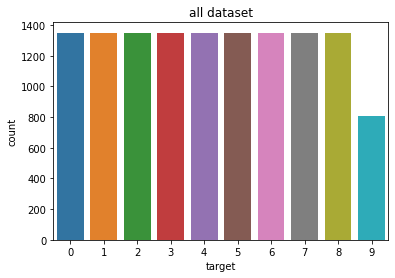

In [13]:
sns.countplot(x = df.noisy_labels_0, data=df)
plt.xlabel('target')
plt.title('all dataset')
plt.show()

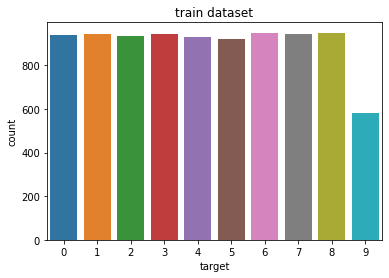

In [14]:
sns.countplot(x = df.noisy_labels_0[df.test == 0], data=df[df.test == 0])
plt.xlabel('target')
plt.title('train dataset')
plt.show()

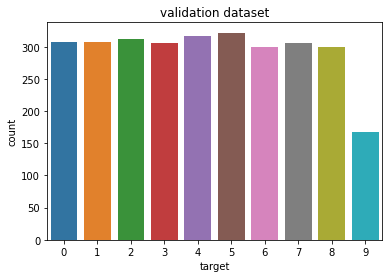

In [15]:
sns.countplot(x = df.noisy_labels_0[df.test == 1], data=df[df.test == 1])
plt.xlabel('target')
plt.title('validation dataset')
plt.show()

In [16]:
train_data = []
test_data = []
def process_train(df):
    data = []
    for image, i in zip(tqdm(df.path, desc = 'Train'), df.index):
        item = {}
        # img = io.imread(image) # считываем каждую картинку
        img = Image.open(image) # считываем каждую картинку
        img = transforms.functional.pil_to_tensor(img) 
        if img.shape[0]>3:
            assert(img[:,:,3]!=255).sum()==0 
        if img.shape[0]==1:
          continue 
        item['img'] = img #добавляем картинку
        item['target'] = df.noisy_labels_0[i] #добавляем таргет
        data.append(item)
    return data

def process_test(df):
    data = []
    for image, i in zip(tqdm(df.path, desc = 'test|val'), df.index):
        item = {}
        # img = io.imread(image) # считываем каждую картинку
        img = Image.open(image)# считываем каждую картинку
        img = transforms.functional.pil_to_tensor(img)
        if img.shape[0]>3:
            assert(img[:,:,3]!=255).sum()==0 
        if img.shape[0]==1:
          continue
        item['img'] = img #добавляем картинку
        item['target'] = df.noisy_labels_0[i] #добавляем таргет
        data.append(item)
    return data
# train_data = process_train(df[df.test == 0])
# # valid_data = process_test(df[df.test == 1])
# test_data = process_test(df[df.test == 2])
train_data = process_train(df[df.is_valid == False])
valid_data = process_test(df[df.is_valid == True])


Train:   0%|          | 0/9025 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:169: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.as_tensor(np.asarray(pic))
Train: 100%|██████████| 9025/9025 [00:56<00:00, 158.92it/s]
test|val: 100%|██████████| 3929/3929 [00:24<00:00, 161.16it/s]


In [25]:
(len(train_data),len(valid_data))

(8943, 3890)

# Так как в train у нас в два раза меньше класса "9", чем остальных, мы можем сделать аугментацию, к примеру повернуть картинки класса "9", на случайный угол, ответ классификатора, естественно поменяться не должен

In [26]:
# import random
# def augmentation(df):
#   data_aug = []
#   for image, i in zip(tqdm(df.path[:10], desc = 'test|val'), df.index[::10]):
#     item = {}
#     img = Image.open(image)
#     img = transforms.functional.pil_to_tensor(img)
#     for j in range(1):
#       ang = int(random.random() * 360)
#       image = transforms.functional.affine(img, angle = ang, translate = (0,0), scale = 1 , shear = 0) #поворачиваем на случайный угол
#     item['img'] = image #добавляем картинки
#     item['target'] = df.noisy_labels_0[i] #добавляем таргет
#     data_aug.append(item)
#   return data_aug

# data_aug_train = augmentation(df[(df.test == 0) & (df.noisy_labels_0 ==9)])
# data_aug_valid = augmentation(df[(df.test == 1) & (df.noisy_labels_0 ==9)])

# train_data = np.concatenate([train_data, data_aug_train])
# valid_data = np.concatenate([valid_data, data_aug_valid])




In [27]:
# len(train_data)

In [28]:
# image,label  = train_data[500].values()
# image = image.reshape(image.shape[1], image.shape[2], image.shape[0])
# for i in range(len(valid_data)):
#   image,label  = valid_data[i].values()
#   if image.shape[0] ==3:
#     print(image.shape)

# 2) Создаём Dataset (изменяем размеры, аугмуентация, нормализация)

In [29]:
###схема трансформации картинки###
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((150,150)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
    
])

transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((150,150)), 
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
])

In [30]:
class Dataset(): #создаём датасет
    def __init__(self, data, source_transform):  #задаём, как мы хотим трансформировать призник и таргет
        self.datas = data
        self.s_transform = source_transform
        self.pil_transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((128,128))])
        self.normalize_tr = transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])])
    
    def __getitem__(self, index): 
        data = self.datas[index] # берем элемент data
        img = data['img'] # достаем картинку 
        target = data['target']
        img = self.s_transform(img) #применяем трансформ к картинке
        return img,target
    
    def __len__(self):
        return len(self.datas)
    
    

class TestDataset(): #создаём датасет
    def __init__(self, data, source_transform):  #задаём, как мы хотим трансформировать призник и таргет
        self.datas = data
        self.s_transform = source_transform
        self.pil_transform = transforms.Compose([transforms.ToPILImage(),
                                                 transforms.Resize((128,128))])
        self.normalize_tr = transforms.Compose([transforms.ToTensor(),
                                                transforms.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])])
    
    def __getitem__(self, index): 
        data = self.datas[index] # берем элемент data
        img = data['img'] # достаем картинку 
        target = data['target']
        img = self.s_transform(img) #применяем трансформ к картинке
        return img, target
    
    def __len__(self):
        return len(self.datas)

In [31]:
train_dataset = Dataset(train_data, transform_train)
valid_dataset = TestDataset(valid_data, transform_test)
test_dataset = TestDataset(test_data, transform_test)

In [32]:
image,label  = valid_dataset[0]
print(image.shape, label)

torch.Size([3, 150, 150]) 0


In [33]:
batch_size=128
train_dl = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0, pin_memory=True)
valid_dl = DataLoader(valid_dataset, batch_size, num_workers=0, pin_memory=True)
# pred_dl = DataLoader(pred_ds, batch_size, num_workers=4, pin_memory=True)

#3) Построение и обучение моделей

In [34]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [35]:
from torchvision import models

In [36]:
# modelvgg = models.vgg19(pretrained = True)

In [37]:
# modelvgg

In [40]:
modelresnet = models.resnet.wide_resnet101_2(pretrained = True)

In [41]:
# modeldensenet = models.densenet121(pretrained = True)

In [42]:
# modeldensenet

In [43]:
modelresnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [44]:
for p in modelresnet.parameters() :
    p.requires_grad = True

In [45]:
# for p in modelvgg.parameters() :
#     p.requires_grad = True

In [46]:
# for p in modeldensenet.parameters() :
#     p.requires_grad = True

In [47]:
# #изменяем классификатор vgg под нашу задачу 
# modelvgg.Linear= nn.Sequential(nn.Linear(4096, 2048, bias = True), 
#                                     nn.ReLU(),
#                                     nn.Linear(2048, 1024, bias = True), 
#                                     nn.ReLU(),
#                                     nn.Dropout(p = 0.6),
#                                     nn.Linear(1024, 512, bias = True),
#                                     nn.ReLU(),
#                                     nn.Linear(512, 10, bias = True),
#                                     nn.LogSoftmax(dim = 1))

In [48]:
#изменяем классификатор resnet под нашу задачу
modelresnet.fc = nn.Sequential(nn.Linear(2048, 1024, bias = True), 
                                    nn.ReLU(),
                                    nn.Dropout(p = 0.6),
                                    nn.Linear(1024, 512, bias = True),
                                    nn.ReLU(),
                                    nn.Linear(512, 10, bias = True),
                                    nn.LogSoftmax(dim = 1))

In [49]:
# # изменяем классификатор efficient под нашу задачу
# modeldensenet.classifier = nn.Sequential(nn.Linear(1024, 512, bias=True),
#                                     nn.ReLU(),
#                                     nn.Linear(512, 128, bias = True), 
#                                     nn.ReLU(),
#                                     nn.Dropout(p = 0.6),
#                                     nn.Linear(128, 10, bias = True),
#                                     nn.LogSoftmax(dim = 1))

In [50]:
loss_function = F.cross_entropy
# loss_function = nn.BCELoss()

In [51]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # выдём предсказания
        loss = loss_function(out, labels) # считаем loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # выдём предсказания
        loss = loss_function(out, labels)   # считаем loss
        acc = accuracy(out, labels)           # считаем accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # считаем средний loss за эпохе
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # считаем accuracy за эпоху
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [52]:
class IntelCnnModelvgg(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = modelvgg
    
    def forward(self, xb):
        return self.network(xb)

In [53]:
class IntelCnnModelresnet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = modelresnet
    
    def forward(self, xb):
        return self.network(xb)

In [54]:
class IntelCnnModeldensenet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = modeldensenet
    
    def forward(self, xb):
        return self.network(xb)

In [55]:
# model1 = IntelCnnModelvgg()
model2 = IntelCnnModelresnet()
# model3 = IntelCnnModeldensenet()

In [56]:
#проверка устройства(что работает в данный момент)
def get_default_device():
  if torch.cuda.is_available:
    return torch.device('cuda')
  else:
    return torch.device('cpu')

In [57]:
device = get_default_device()
device

device(type='cuda')

In [58]:
#перемещение тензоров на конкретное утройство
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [59]:
#перемещение данных на конкретное устройство
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [60]:
# #переводим данные
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)
# # pred_dl = DeviceDataLoader(pred_dl, device)
# to_device(model1, device);

In [61]:
#графики loss
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss')

In [62]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()   #eval() is called to tell model that now it is validation mode and so don't perform stuff like dropout,backpropagation etc..
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        #Тренируем 
        model.train() #eval() is called to tell model that now it is training mode and so  perform stuff like dropout,backpropagation etc..
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        #резльтат
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        # clear_output(True)
        # plot_losses(history)
        # plt.show()
    return history

## Модель VGG19

In [63]:
# model1 = to_device(IntelCnnModelvgg(), device)
# # model = to_device(model, device)
# evaluate(model1, valid_dl)

In [64]:
# num_epochs = 10
# opt_func = torch.optim.Adam
# lr = 0.00001
# history = fit(num_epochs, lr, model1, train_dl, valid_dl, opt_func)
# evaluate(model1, valid_dl)

In [65]:
# evaluate(model1, valid_dl)

## Модель ResNet



In [66]:
model2 = to_device(IntelCnnModelresnet(), device)
# model = to_device(model, device)
evaluate(model2, valid_dl)

{'val_acc': 0.11214717477560043, 'val_loss': 2.3005154132843018}

In [67]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.00001
history = fit(num_epochs, lr, model2, train_dl, valid_dl, opt_func)
evaluate(model2, valid_dl)

Epoch [0], train_loss: 2.2213, val_loss: 1.8987, val_acc: 0.7986
Epoch [1], train_loss: 1.7499, val_loss: 1.0211, val_acc: 0.8508
Epoch [2], train_loss: 0.9293, val_loss: 0.4948, val_acc: 0.8675
Epoch [3], train_loss: 0.4569, val_loss: 0.2972, val_acc: 0.9203
Epoch [4], train_loss: 0.2674, val_loss: 0.2443, val_acc: 0.9288
Epoch [5], train_loss: 0.1865, val_loss: 0.2261, val_acc: 0.9273
Epoch [6], train_loss: 0.1312, val_loss: 0.2242, val_acc: 0.9301
Epoch [7], train_loss: 0.1001, val_loss: 0.2276, val_acc: 0.9289
Epoch [8], train_loss: 0.0821, val_loss: 0.2284, val_acc: 0.9287
Epoch [9], train_loss: 0.0644, val_loss: 0.2294, val_acc: 0.9266


{'val_acc': 0.9266229271888733, 'val_loss': 0.22937016189098358}

In [103]:
# evaluate(model2, valid_dl)

Во время обучения протестил несколько моделей, вот лучшие результаты

In [101]:
results

model,val_accuracy
WideResNet-101-2,0.930100
Resnet152,0.926500
Resnet101,0.925400
Densenet121,0.904700
Resnet50,0.900200
Vgg19,0.887300
Densenet169,0.886200


## Модель Densenet-121

In [68]:
# model3 = to_device(IntelCnnModeldensenet(), device)
# model3 = to_device(model3, device)
# evaluate(model3, valid_dl)

In [69]:
# num_epochs = 100
# opt_func = torch.optim.Adam
# lr = 0.00001
# history = fit(num_epochs, lr, model3, train_dl, valid_dl, opt_func)
# evaluate(model3, valid_dl)

In [70]:
# evaluate(model3, valid_dl)

## 5)Предсказание

In [71]:
#функция предсказания на общем Тесте

# def predict_single(input,label, model):
#     input = to_device(input,device)
#     inputs = input.unsqueeze(0)   # unsqueeze the input i.e. add an additonal dimension
#     predictions = model(inputs)
#     prediction = predictions[0].detach().cpu()
#     print(f"Предсказала {np.argmax(prediction)}, должна была предсказать {label}")

In [72]:
# for i,img in enumerate(test_dataset):
#   print(img[0], img[1])
#   predict_single(img[0],img[1], model1)
#   break

In [97]:
results = pd.DataFrame({'model':['Resnet50','Resnet101', 'Resnet152', 'WideResNet-101-2', 'Vgg19', 'Densenet169', 'Densenet121' ],'val_accuracy':[0.9002, 0.9254, 0.9265, 0.9301, 0.8873, 0.8862, 0.9047  ]})

In [98]:
results = results.sort_values(by ='val_accuracy', ascending=False)


In [99]:
results = results.style.hide_index()

In [100]:
results

model,val_accuracy
WideResNet-101-2,0.930100
Resnet152,0.926500
Resnet101,0.925400
Densenet121,0.904700
Resnet50,0.900200
Vgg19,0.887300
Densenet169,0.886200
